In [2]:
import pysumma as ps
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pysumma.plotting as psp
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
import matplotlib.colors as colors
import datetime

In [4]:
ds = xr.open_dataset('../model/forcings/cssl_WY23.nc')
ds

<xarray.Dataset>
Dimensions:     (time: 8745, hru: 1)
Coordinates:
  * time        (time) datetime64[ns] 2022-10-01 ... 2023-09-30T08:00:00
Dimensions without coordinates: hru
Data variables:
    airtemp     (time, hru) float64 ...
    pptrate     (time, hru) float64 ...
    airpres     (time, hru) float64 ...
    spechum     (time, hru) float64 ...
    SWRadAtm    (time, hru) float64 ...
    LWRadAtm    (time, hru) float64 ...
    windspd     (time, hru) float64 ...
    gap_filled  (hru, time) float64 ...
    data_step   float64 ...
    hruId       (hru) int32 ...

In [2]:
wellscreek_WY25_ds = xr.open_dataset('/home/cdalden/summa_setup/model/output/output_wellscreek_WY25_timestep.nc')
heathermeadows_24_df = pd.read_csv('/home/cdalden/summa_setup/model/forcings/MtBaker-HeatherMeadows_4210_2024.csv')
heathermeadows_25_df = pd.read_csv('/home/cdalden/summa_setup/model/forcings/MtBaker-HeatherMeadows_4210_2025.csv')

heathermeadows_24_df['time'] = pd.to_datetime(heathermeadows_24_df['time'])
heathermeadows_24_df.set_index('time', inplace=True)

heathermeadows_25_df['time'] = pd.to_datetime(heathermeadows_25_df['time'])
heathermeadows_25_df.set_index('time', inplace=True)

# combine the two dataframes
heathermeadows_df = pd.concat([heathermeadows_24_df, heathermeadows_25_df])

# Sort the index to ensure it is monotonic
heathermeadows_df.sort_index(inplace=True)

time_range = slice('12-01-2024', '02-06-2025')
heathermeadows_df = heathermeadows_df[time_range]
wellscreek_WY25_ds = wellscreek_WY25_ds.sel(time=time_range)


In [29]:
# gap fill heathermeadows data
# set all  0 snow depth values to nan
heathermeadows_df.loc[heathermeadows_df['Total Snow Depth'] < 0.1, 'Total Snow Depth'] = np.nan
heathermeadows_df.loc[heathermeadows_df['Total Snow Depth']*0.0254 > 4, 'Total Snow Depth'] = np.nan

# interpolate the snow depth
heathermeadows_df['Total Snow Depth'] = heathermeadows_df['Total Snow Depth'].interpolate()

# heather meadows daily precip
heathermeadows_daily_df = heathermeadows_df.resample('D').sum()


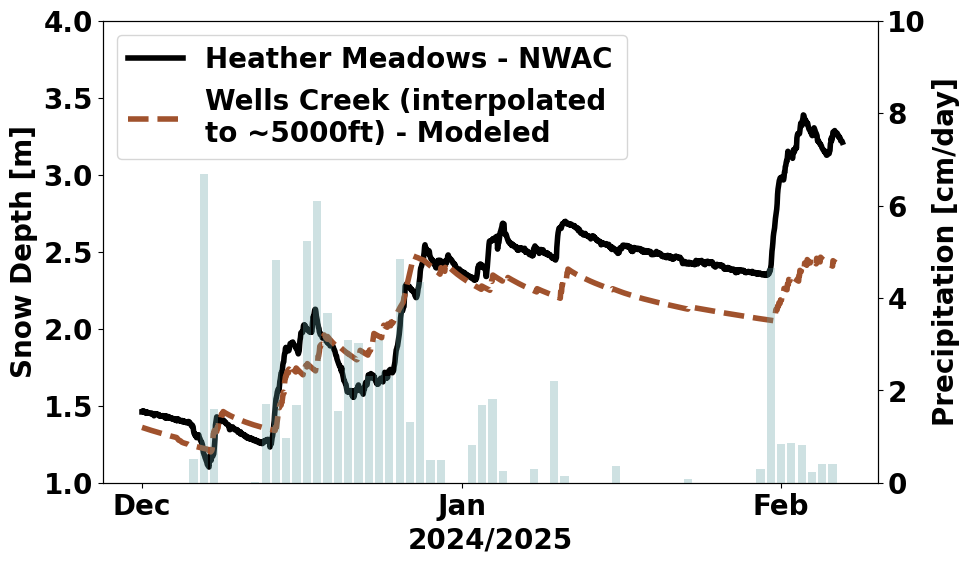

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(heathermeadows_df.index, heathermeadows_df['Total Snow Depth']*0.0254, 
        label='Heather Meadows - NWAC', color='black', lw=4)
ax.plot(wellscreek_WY25_ds['time'], wellscreek_WY25_ds['scalarSnowDepth'], 
        label='Wells Creek (interpolated \nto ~5000ft) - Modeled', color='sienna', ls='--', lw=4)

# Create a secondary y-axis for pptrate
ax2 = ax.twinx()
# ax2.bar(df.index, df['pptrate'], color='cadetblue', alpha=0.3, width=0.1, label='Precip.')
ax2.bar(heathermeadows_daily_df.index, heathermeadows_daily_df['Precipitation']*2.54, color='cadetblue', alpha=0.3, width=0.8, label=r'$\mathbf{Precip.}$')
ax2.set_ylabel('Precipitation [cm/day]', fontsize=20, fontweight='bold')
ax2.set_ylim(0, 10)



ax.set_ylabel('Snow Depth [m]', fontsize=20, fontweight='bold')
ax.set_ylim(1, 4)
ax.set_xlabel('2024/2025', fontsize=20, fontweight='bold')
# Create a FontProperties object with the desired properties
font_properties = FontProperties(weight='bold', size=20)

# Set the legend with the specified font properties
ax.legend(prop=font_properties)

# Change the fontsize and fontweight of x tick labels
font_properties = FontProperties(weight='bold', size=20)
for label in ax.get_xticklabels() + ax.get_yticklabels() + ax2.get_yticklabels():
    label.set_fontproperties(font_properties)

# Set the date format for x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# Ensure each month is only plotted once
ax.xaxis.set_major_locator(mdates.MonthLocator())


## Plot temps and density

In [5]:
ds         =    wellscreek_WY25_ds
depth      =    ds.isel(hru=0).sel(time=time_range)['iLayerHeight']
temp       =    ds.isel(hru=0).sel(time=time_range)['mLayerTemp']
temp       =    temp.where((temp == -9999) | np.isnan(temp), temp - 273.15)
frac_liq   =    ds.isel(hru=0).sel(time=time_range)['mLayerVolFracLiq']
frac_wat   =    ds.isel(hru=0).sel(time=time_range)['mLayerVolFracWat']
frac_wat   =    frac_wat.where((frac_wat == -9999) | np.isnan(frac_wat), frac_wat * 1000)
snow_depth =    ds.isel(hru=0).sel(time=time_range)['scalarSnowDepth']

In [6]:
# Create colomaps
# The range of temperature bins in Celsius
a = np.arange(-10,0,1)
# Bins normalized between 0 and 1
norm = [(float(i)-min(a))/(max(a)-min(a)) for i in a]
# Color tuple for every bin
C = np.array([[145,0,63],
              [206,18,86],
              [231,41,138],
              [223,101,176],
              [255,115,223],
              [255,190,232],
              [255,255,255],
              [218,218,235],
              [188,189,220],
              [158,154,200],
              [117,107,177],
              [84,39,143],
              [13,0,125],
              [13,61,156],
              [0,102,194],
              [41,158,255],
              [74,199,255],
              [115,215,255],
              [173,255,255],
              [48,207,194],
              [0,153,150],
              [18,87,87],
              [6,109,44],
              [49,163,84],
              [116,196,118],
              [161,217,155],
              [211,255,190],
              [255,255,179],
              [255,237,160],
              [254,209,118],
              [254,174,42],
              [253,141,60],
              [252,78,42],
              [227,26,28],
              [177,0,38],
              [128,0,38],
              [89,0,66],
              [40,0,40]])/255.
# Create a tuple for every color indicating the normalized position on the colormap and the assigned color.
COLORS = []
for i, n in enumerate(norm):
    COLORS.append((n, C[i]))
temp_cmap = colors.LinearSegmentedColormap.from_list("Temperature", COLORS)
# Reverse the colormap
temp_cmap_r = temp_cmap.reversed()

AttributeError: 'Axes' object has no attribute 'ax'

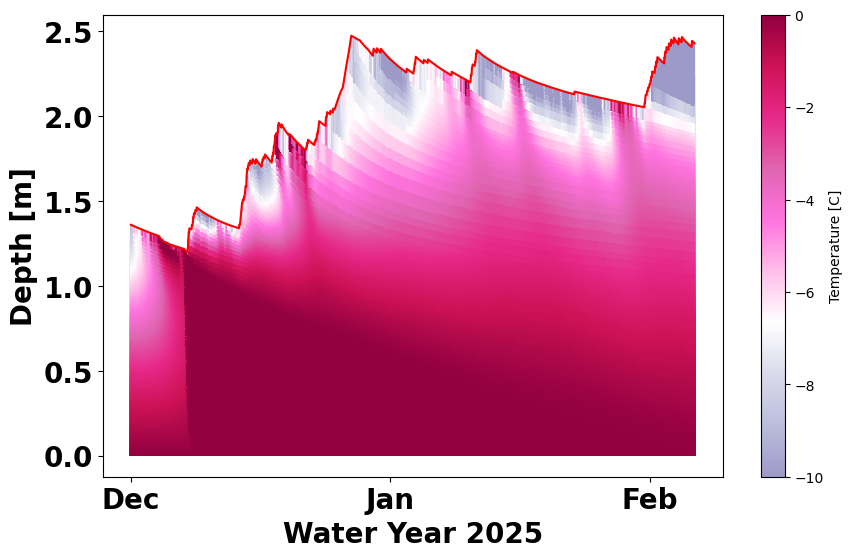

In [44]:
# Define cbar_kwargs with label
cbar_kwargs = {'label': 'Temperature [C]'}

fig, ax = plt.subplots(figsize=(10, 6))

# Assuming layers returns a tuple and the first element is the colorbar
cbar, _ = psp.layers(temp, depth, plot_soil=False, variable_range=[-10, 0], ax=ax, 
                     cbar_kwargs=cbar_kwargs, colormap=temp_cmap_r)

# Set the colorbar label
cbar.set_label('Density [kg m-3]')

# Plot additional data
ax.plot(snow_depth.time, snow_depth, c='r')
ax.set_xlabel('Water Year 2025', fontweight='bold', fontsize=20)
ax.set_ylabel('Depth [m]', fontweight='bold', fontsize=20)

# Set the date format for x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# Ensure each month is only plotted once
ax.xaxis.set_major_locator(mdates.MonthLocator())

# Change the fontsize and fontweight of x tick labels
font_properties = FontProperties(weight='bold', size=20)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(font_properties)

# ax.set_ylim(0, 2.5)

# Set the tick label font properties
cbar.ax.tick_params(labelsize=50, labelweight='bold')

## Density Plot

AttributeError: 'Axes' object has no attribute 'ax'

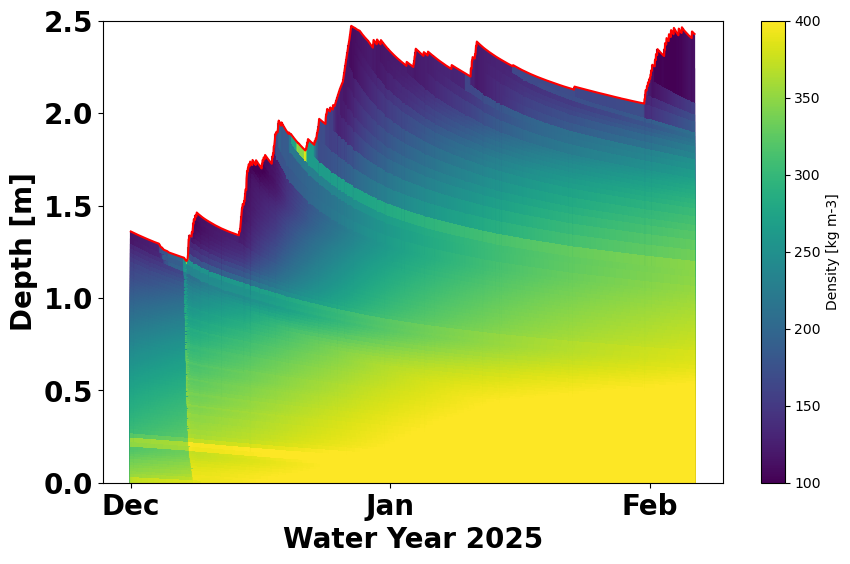

In [10]:
cbar_kwargs = {'label': 'Density [kg m-3]'}

fig, ax = plt.subplots(figsize=(10, 6))

# Assuming layers returns a tuple and the first element is the colorbar
cbar, _ = psp.layers(frac_wat, depth, plot_soil=False, variable_range=[100, 400], ax=ax, 
                     cbar_kwargs=cbar_kwargs, colormap='viridis')

# Set the colorbar label
cbar.set_label('Density [kg m-3]')


# Plot additional data
ax.plot(snow_depth.time, snow_depth, c='r')
ax.set_xlabel('Water Year 2025', fontweight='bold', fontsize=20)
ax.set_ylabel('Depth [m]', fontweight='bold', fontsize=20)
# ax.axvline(datetime.datetime(2024, 1, 23), color='r', linestyle='--')
# ax.axvline(datetime.datetime(2023, 12, 22), color='r', linestyle='--')
# ax.axvline(datetime.datetime(2024, 2, 10), color='r', linestyle='--')

# Set the date format for x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# Ensure each month is only plotted once
ax.xaxis.set_major_locator(mdates.MonthLocator())

ax.set_ylim(0, 2.5)

# Change the fontsize and fontweight of x tick labels
font_properties = FontProperties(weight='bold', size=20)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontproperties(font_properties)



# Set the tick label font properties
cbar.ax.tick_params(labelsize=50, labelweight='bold')